In [72]:
import matplotlib.pyplot as pp
import numpy as np
import copy

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm

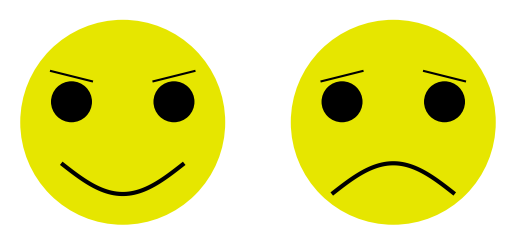

In [1]:
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
    'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
    'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
    'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
    'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
    'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
    'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
    base_face()
    for i in face: 
        patches[i]()
    pp.axis('scaled')
    pp.axis('off')
  
f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

In [2]:
def has_overlap(face):
    # Can't have two overlapping eyebrows!
    if 'left_eb_down' in face and 'left_eb_up' in face:
        return True
    if 'right_eb_down' in face and 'right_eb_up' in face:
        return True
    # Can't have two overlapping mouths!
    if 'smile' in face and 'frown' in face:
        return True
    return False

def face_reward(face):
    if has_overlap(face):
        return 0
    eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
    # Must have exactly two eyebrows
    if sum([i in face for i in eyebrows]) != 2:
        return 0
    # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
    if 'smile' in face:
        return 2
    if 'frown' in face:
        return 1  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
    return 0
  

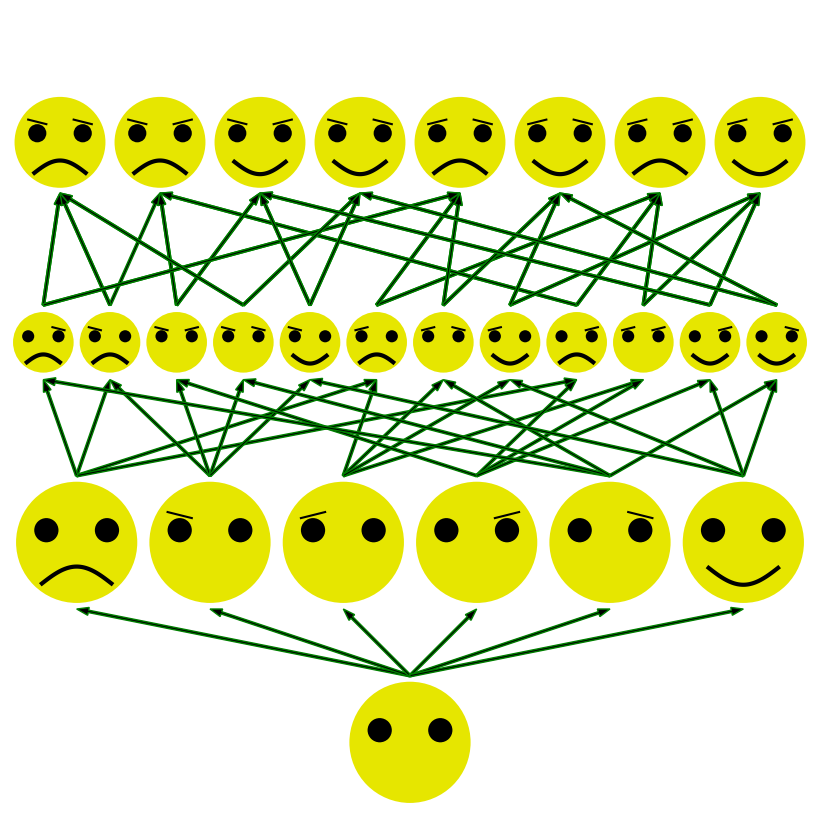

In [3]:
#@title
enumerated_states = []
transitions = []
def recursively_enumerate(s):
    if has_overlap(s):
        return
    for i in sorted_keys:
        if i not in s:
            recursively_enumerate(s+[i])
    enumerated_states.append(s)
    transitions.append((s[:-1], s))
recursively_enumerate([])
unique = []
for i in map(set, enumerated_states):
    if i not in unique:
        unique.append(i)
enumerated_states = sorted(map(tuple, unique))

lens = [len([i for i in enumerated_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in enumerated_states if len(i) == j]) for j in range(4)]
f = pp.figure(figsize=(8, 8))
def face_hash(face):
    return tuple([i in face for i in sorted_keys])
face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
    for j, face in enumerate(level):
        ax = f.add_axes([j/L, i/4, 1/L, 1/6])
        draw_face(face)
        face2pos[face_hash(face)] = (j/L+0.5/L, i/4)
ax = f.add_axes([0,0,1,1])
pp.sca(ax)
pp.gca().set_facecolor((0,0,0,0))
pp.xlim(0,1)
pp.ylim(0,1)
for a, b in transitions[1:]:
    pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
    if not len(b): continue
    lb = int(pb[1] * 4) 
    la = int(pa[1] * 4) 
    ws = [1/6,1/6,0.13,0.11]
    pp.arrow(pa[0],pa[1]+ws[la],pb[0]-pa[0],pb[1]-pa[1]-ws[lb], head_width=0.01, width=0.003, ec=(0.,0.5,0),fc=(0,0,0),
             length_includes_head=True)
    pp.axis('off')


# Modeling

In [4]:
# 1번의 진행마다 (좌눈썹, 우눈썹, 입) 이 하나씩 추가 됨.
# 온전한 얼굴을 만들지 못한 경우 0점
# 입이 찡그린 얼굴을 완성한 경우 1점
# 입이 웃고있는 얼굴을 완성한 경우 2점

def face_to_tensor(face):
    return torch.tensor([i in face for i in sorted_keys]).float()

class FlowModel(nn.Module):
    def __init__(self, num_hid):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(6, num_hid), nn.LeakyReLU(),
                             nn.Linear(num_hid, 6))
    def forward(self, x):
        F = self.mlp(x).exp() * (1 - x)
        return F

def face_parents(state):
    parent_states = [] 
    parent_actions = []
    for face_part in state:
        parent_states.append([i for i in state if i != face_part])
        parent_actions.append(sorted_keys.index(face_part))
    return parent_states, parent_actions

def face_parents(state):
    parent_states = []
    parent_actions = [] 
    for face_part in state:
        parent_states.append([i for i in state if i != face_part])
        parent_actions.append(sorted_keys.index(face_part))
    return parent_states, parent_actions

# Experiments

In [52]:
# 2차항이 포함된 모델과 1차항 모델 각각 10000 epoch 학습 후 결과 관찰
# 각각 모델에 대해 400번씩 실험 


def train_func(model, epochs, energy_term_flag = False):
    opt = torch.optim.Adam(F_sa_original.parameters(), 3e-4)
    losses = []
    sampled_faces = []
    minibatch_loss = 0
    update_freq = 4
    for episode in range(epochs):
        state = []
        edge_flow_prediction = model(face_to_tensor(state))
        for t in range(3):
            policy = edge_flow_prediction / edge_flow_prediction.sum()
            action = Categorical(probs=policy).sample()
            new_state = state + [sorted_keys[action]]
    
            parent_states, parent_actions = face_parents(new_state)
            px = torch.stack([face_to_tensor(p) for p in parent_states])
            pa = torch.tensor(parent_actions).long()
            parent_edge_flow_preds = model(px)[torch.arange(len(parent_states)), pa]
            
            if t == 2:
                reward = face_reward(new_state)
                edge_flow_prediction = torch.zeros(6)
            else:
                reward = 0
                edge_flow_prediction = model(face_to_tensor(new_state))
    
            flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
            minibatch_loss += flow_mismatch  
            
            if energy_term_flag:
                energy_mismatch = torch.abs((parent_edge_flow_preds.pow(2).sum() - edge_flow_prediction.pow(2).sum()))
                minibatch_loss += energy_mismatch
                
            state = new_state
    
        sampled_faces.append(state)
        if episode % update_freq == 0:
            losses.append(minibatch_loss.item())
            minibatch_loss.backward()
            opt.step()
            opt.zero_grad()
            minibatch_loss = 0

    return [sum(['smile' in i for i in sampled_faces[-128:]]) / 128, sum([face_reward(i) > 0 for i in sampled_faces[-128:]]) / 128]

In [63]:
epochs = 10000
experiments = 400

original_result = []
second_order_term_result = []

for _ in tqdm.tqdm(range(experiments)):
    F_sa_original = FlowModel(512)
    F_sa_second_order_term = copy.deepcopy(F_sa_original)
    
    original_result.append(train_func(F_sa_original, epochs, energy_term_flag = False))
    second_order_term_result.append(train_func(F_sa_second_order_term, epochs, energy_term_flag = True))
    
with open('original_result.npy', 'wb') as f:
    np.save(f, np.array(original_result))
    
with open('second_order_term_result.npy', 'wb') as f:
    np.save(f, np.array(second_order_term_result))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [6:46:17<00:00, 60.94s/it]


In [65]:
with open('original_result.npy', 'rb') as f:
    origin = np.load(f)
    
with open('second_order_term_result.npy', 'rb') as f:
    sot = np.load(f)

In [70]:
print(origin.mean(axis = 0))
print(origin.std(axis = 0))

[0.91972656 0.89419922]
[0.02598097 0.02949485]


In [71]:
print(sot.mean(axis = 0))
print(sot.std(axis = 0))

[0.49904297 0.40205078]
[0.05926568 0.04545948]
